Setup (Packages, Data)

In [1]:
#loading packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import pyvista as pv
import cdd as pcdd
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy import sparse
from scipy.spatial.distance import cdist
import time
from shapely.geometry import Polygon
from matplotlib.patches import Ellipse, Arc

import warnings
warnings.filterwarnings('ignore')

#setting to view all columns at once
pd.options.display.max_columns = None

In [2]:
#reading in provided datasets
events = pd.read_csv('events.csv')
possessions = pd.read_csv('possessions.csv')
tracking = pd.read_csv('tracking.csv')

In [3]:
#reading in external datasets
#downloaded from Basketball Reference
teamratings = pd.read_csv('2223teamratings.csv')[:-1]

Data Wrangling (Merges, Nulls, Grouping)

In [4]:
#merge possessions and events dataframes on gameId and UTC timestamps
merged_df = possessions.merge(events, on=['gameId'], how='inner')

merged_df = merged_df[(merged_df['wcTime'] >= merged_df['wcStart']) & (merged_df['wcTime'] <= merged_df['wcEnd'])]

#selecting columns to keep and sorting by gameId, possession number, and wcTime
merged_df = merged_df[['gameId','period_x','possNum','teamId_x','teamAbbr_x','outcome','ptsScored','wcStart','wcEnd',
                       'gcStart','gcEnd','basketX','eventType','playerId','playerName','teamId_y','teamAbbr_y','wcTime','wcTimeEnd',
                       'gcTime','scTime','fouledId','fouledName','foulType','made','three','fouled','assisted','receiverId',
                       'receiverName','distance','dReb','defenderProximity','defenderId','defenderName']].sort_values(by=['gameId','possNum','wcTime'])

#merge previously merged dataframe with tracking data on gameId and wcTime
merged_df = merged_df.merge(tracking[['gameId','playerId','playerName','teamId','teamAbbr','wcTime','x','y','z']], on=["gameId", "wcTime"], how="left")

In [5]:
#get number of null values in each column
merged_df.isnull().sum()

gameId                    0
period_x                  0
possNum                   0
teamId_x                  0
teamAbbr_x                0
outcome                   0
ptsScored                 0
wcStart                   0
wcEnd                     0
gcStart                   0
gcEnd                     0
basketX                   0
eventType                 0
playerId_x              388
playerName_x            388
teamId_y                 96
teamAbbr_y               96
wcTime                    0
wcTimeEnd            253258
gcTime                    0
scTime                    0
fouledId             399060
fouledName           399060
foulType             399050
made                 377490
three                377901
fouled               377901
assisted             377901
receiverId           344440
receiverName         344440
distance             307040
dReb                 383376
defenderProximity    362020
defenderId           362020
defenderName         362020
playerId_y          

In [6]:
#drop rows with null values in x, y, or z columns
merged_df = merged_df.dropna(subset=['x','y','z'])

In [7]:
merged_df.shape

(395505, 42)

In [8]:
#divide merged_df into groups of 11 rows (one frame)
grouped = merged_df.groupby(np.arange(len(merged_df))//11)

Functions for Parsing the Data by Frame

In [9]:
#input a frame number as an int and get the resulting frame (11 rows of data) as a dataframe
def getFrame(frameNum):
    return grouped.get_group(frameNum)

In [10]:
#given a frame of data (11 rows, one for each player and the ball), build convex hulls for team shape
#input a dataframe and return a tuple containing the coordinates of team 1 players, convex hull for team 1, the same for team 2, and the ball coords
def buildConvexHull(frame):
    team1_points = frame[['x','y']].iloc[0:5].values
    team2_points = frame[['x','y']].iloc[5:10].values
    ball_points = frame[['x','y']].iloc[10].values
    side = frame['basketX'].iloc[0]

    #create convex hulls for each team
    hull1 = ConvexHull(team1_points)
    hull2 = ConvexHull(team2_points)

    return(team1_points, hull1, team2_points, hull2, ball_points, side)

In [11]:
#helper function to draw a semicircle for the 3pt arc
def draw_semicircle(x1, y1, x2, y2, color='black', lw=1, ax=None, angle=0):
    ax = ax or plt.gca()
    # ax. Scatter([x1, x2], [y1, y2], s=100, c=color)
    startangle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    diameter = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  # Euclidian distance
    ax.add_patch(Arc(((x1 + x2) / 2, (y1 + y2) / 2), diameter, diameter, angle = angle, theta1=startangle, theta2=startangle + 180,
                     edgecolor=color, facecolor='none', lw=lw, zorder=0))

In [12]:
#given the output of buildConvexHull, plot the team shapes and location of the ball
def plotHull(team1_points, hull1, team2_points, hull2, ball_points, side):
    #team 1 in cyan, team 2 in blue, ball in red
    plt.plot(team1_points[:,0], team1_points[:,1], 'o',color='c')
    plt.plot(team2_points[:,0], team2_points[:,1], 'o',color='b')
    plt.plot(ball_points[0], ball_points[1], 'o',color='r')

    for simplex in hull1.simplices:
        plt.plot(team1_points[simplex, 0], team1_points[simplex, 1], 'r')

    for simplex in hull2.simplices:
        plt.plot(team2_points[simplex, 0], team2_points[simplex, 1], 'r')

    plt.plot(team1_points[hull1.vertices,0], team1_points[hull1.vertices,1], 'r', lw=-1)
    plt.plot(team1_points[hull1.vertices[0],0], team1_points[hull1.vertices[0],1], 'r-')
    plt.plot(team2_points[hull2.vertices,0], team2_points[hull2.vertices,1], 'r', lw=-1)
    plt.plot(team2_points[hull2.vertices[0],0], team2_points[hull2.vertices[0],1], 'r-')

    #plot basic paint area and 3pt line for appropriate side of the floor
    #left basket
    if side < 0:
        #basic paint area
        plt.plot([-43, -28], [-6, -6], color='black')
        plt.plot([-43, -28], [6, 6], color='black')
        plt.plot([-28, -28], [-6, 6], color='black')
        plt.plot([-43, -43], [-6, 6], color='black')
        
        #3pt line
        plt.plot([-47, -41.75], [22, 22], color='black')
        plt.plot([-47, -41.75], [-22, -22], color='black')
        draw_semicircle(-41.75, 22, -41.75, -22)
        
    #right basket
    if side > 0:
        #basic paint area
        plt.plot([28, 43], [-6, -6], color='black')
        plt.plot([28, 43], [6, 6], color='black')
        plt.plot([28, 28], [-6, 6], color='black')
        plt.plot([43, 43], [-6, 6], color='black')
        
        #3pt line
        plt.plot([41.75, 47], [22, 22], color='black')
        plt.plot([41.75, 47], [-22, -22], color='black')
        draw_semicircle(41.75, 22, 41.75, -22, angle=180)

    plt.show()

In [13]:
#given the output of buildConvexHull minus location of the ball, return area of intersection of the two team shapes as an int (0 if no intersection)
def getIntersectArea(team1_points, hull1, team2_points, hull2):
    #get intersection of two convex hulls
    poly1 = Polygon(team1_points[hull1.vertices])
    poly2 = Polygon(team2_points[hull2.vertices])
    if(poly1.intersects(poly2)):
        return poly1.intersection(poly2).area
    else: return 0

Metric Part 1: Calculating Percentage of Paint Covered by Defensive Team Shape

In [14]:
#given the defensive team convexHull, return the area of intersection of the defensive team shape and paint/3pt arc areas as an int
#return area of intersection between defense convex hull and paint as a percentage of the paint area
def getIntersectAreaDef(team_points, hull, side):
    def_poly = Polygon(team_points[hull.vertices])
    if side < 0:
        coords = ((-43,-6), (-43,6), (-28,6), (-28,-6))
        paint_poly = Polygon(coords)
    else:
        coords = ((28,-6), (43,-6), (43,6), (28,6))
        paint_poly = Polygon(coords)
    if(def_poly.intersects(paint_poly)):
        return def_poly.intersection(paint_poly).area / ConvexHull(coords).volume
    else: return 0

In [15]:
#a naive check for whether or not the current frame is an instance of halfcourt offense
#trying to filter out transition/early offense so that we can examine defense in a consistent halfcourt setting
#looking for the intersection of the two team convex hulls to be at least 30% of the volume of one of the hulls
#return a boolean with True if halfcourt offense, False if not
def isHalfcourt(frame):
    team1_points, hull1, team2_points, hull2 = buildConvexHull(frame)[0:4]
    intersectArea = getIntersectArea(team1_points, hull1, team2_points, hull2)
    if intersectArea >= 0.3 * hull1.volume or intersectArea >= 0.3 * hull2.volume:
        return True
    else: return False

In [16]:
#function to get the situation for a given frame number
#includes building and plotting team convex hulls, returning total intersecting area, and checking if it is a halfcourt situation
#option to plot the frame or not given the use case
def getSituation(frameNum, plot=True):
    frame = getFrame(frameNum)
    team1_points, hull1, team2_points, hull2, ball_points, side = buildConvexHull(frame)
    if plot == True:
        plotHull(team1_points, hull1, team2_points, hull2, ball_points, side)
    if (frame.iloc[0]['teamAbbr'] == frame.iloc[0]['teamAbbr_y']):
        return(getIntersectAreaDef(team2_points, hull2, side))
    else:
        return(getIntersectAreaDef(team1_points, hull1, side))

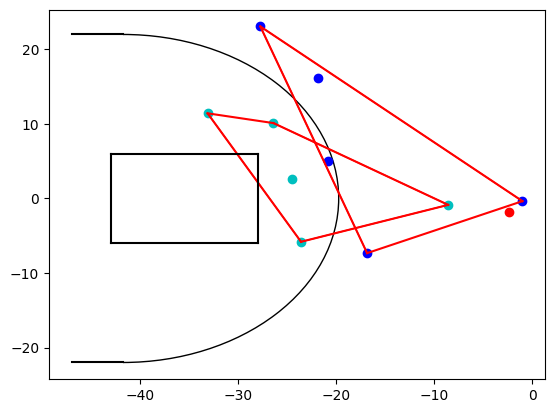

0.022617806104016487

In [17]:
getSituation(4)

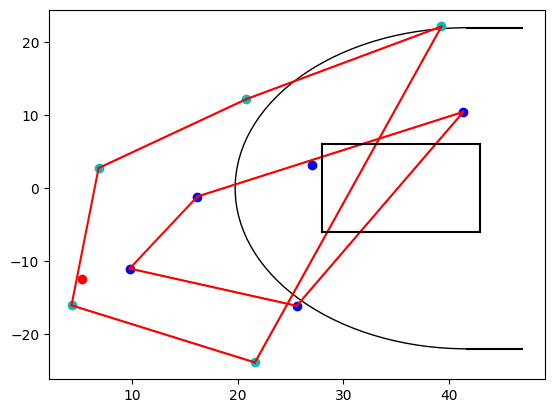

0.46088287404556905

In [18]:
getSituation(25)

Filtering Data to Halfcourt Situations Only

In [19]:
#filter merged_df grouped dataframe to only include frames that are halfcourt situations
grouped_filtered = grouped.filter(lambda group: isHalfcourt(group))

In [20]:
grouped_filtered.shape

(350196, 42)

Metric Part 2: Nearest Defender/Nearest Defender Distance

In [21]:
#assigning each row as either offensive or defensive player measurement
def assign_off_def(row):
    if row['teamAbbr'] == row['teamAbbr_y']:
        return 'offense'
    elif  pd.isna(row['playerName_y']):
        return 'ball'
    else:
        return 'defense'

# Apply the function to each frame
grouped_filtered['OFF/DEF'] = grouped_filtered.apply(assign_off_def, axis=1)

In [22]:
#add a new column for the name of the closest defender based on distance only
def find_closest_defense_and_distance(offense_player, defense_players):
    # Calculate pairwise distances between the offense player and defense players
    distances = cdist(np.array([[offense_player['x'], offense_player['y']]]), defense_players[['x', 'y']])
    
    # Print out the minimum distance in the array
    min_distance = np.min(distances)    
    # Find the index of the minimum distance
    closest_defense_index = np.argmin(distances)
    
    # Get the closest defense player and its distance
    closest_defense_player = defense_players.iloc[closest_defense_index]
    distance_to_defense = distances[0, closest_defense_index]
    
    return closest_defense_player['playerName_y'], distance_to_defense

In [23]:
# Iterate over the DataFrame in chunks of 11 rows for each frame
for i in range(0, len(grouped_filtered), 11):
    subset = grouped_filtered.iloc[i:i+11]  # Get subset of 11 rows
    
    # Skip the row where 'OFF/DEF' is 'ball' within the subset
    subset = subset[subset['OFF/DEF'] != 'ball']
    
    # Iterate over offense players within the subset
    closest_defenders = []
    distances_to_defense = []
    for _, offense_player in subset[subset['OFF/DEF'] == 'offense'].iterrows():
        defense_players = subset[subset['OFF/DEF'] == 'defense']
        
        # Check if defense_players is not empty
        if not defense_players.empty:
            closest_defender, distance_to_defense = find_closest_defense_and_distance(offense_player, defense_players)
            closest_defenders.append(closest_defender)
            distances_to_defense.append(distance_to_defense)
        else:
            # If defense_players is empty, append placeholder values
            closest_defenders.append(np.nan)
            distances_to_defense.append(np.nan)
        #print(closest_defender,distances_to_defense)
    
    # Add closest defenders and distances to the subset
    grouped_filtered.loc[subset[subset['OFF/DEF'] == 'offense'].index, 'defender'] = closest_defenders
    grouped_filtered.loc[subset[subset['OFF/DEF'] == 'offense'].index,'distance'] = distances_to_defense

In [24]:
grouped_filtered.reset_index(drop=True, inplace=True)

Combining Paint Area Covered by Defense and Closest Defender Distance to Ballhandler into Metric

In [25]:
#grabbing relevant metrics from each frame
grouped_metrics = grouped_filtered.groupby(np.arange(len(grouped_filtered))//11)

rows = []

for name, group in grouped_metrics:
    team1_points, hull1, team2_points, hull2, ball_points, side = buildConvexHull(group)
    if (group.iloc[0]['teamAbbr'] == group.iloc[0]['teamAbbr_y']):
        paint_coverage = getIntersectAreaDef(team2_points, hull2, side)
    else:
        paint_coverage = getIntersectAreaDef(team1_points, hull1, side)

    teams = group['teamAbbr'].unique().tolist()
    row = group[group['playerName_y'] == group['playerName_x']]
    row['paint_coverage'] = paint_coverage

    rows.append((teams, row[['gameId']].values, row[['period_x']].values, row[['possNum']].values, row[['teamId_x']].values, row[['teamAbbr_x']].values, row[['playerId_x']].values, row[['playerName_x']].values, row[['teamId_y']].values, row[['teamAbbr_y']].values, row[['distance']].values, row[['playerId_y']].values, row[['playerName_y']].values, row[['teamId']].values, row[['teamAbbr']].values, row[['x']].values, row[['y']].values, row[['z']].values, row[['OFF/DEF']].values, row[['defender']].values, row[['paint_coverage']].values))

In [26]:
#building out final metrics dataframe
final = pd.DataFrame(rows, columns = ['teams','gameId', 'period', 'possNum', 'possTeamId', 'possTeamAbbr', 'possPlayerId', 'possPlayerName', 'eventTeamId', 'eventTeamAbbr', 'closestDefenderDistance', 'framePlayerId', 'framePlayerName', 'frameTeamId', 'frameTeamAbbr', 'x', 'y', 'z', 'OFF/DEF', 'closestDefender', 'team_paint_coverage'])
teams_col = final['teams']
final = final.stack().str[0].unstack().stack().str[0].unstack()
final['teams_clean'] = teams_col
final['teams_clean_1'] = final['teams_clean'].apply(lambda col: col[0])
final['teams_clean_2'] = final['teams_clean'].apply(lambda col: col[1])

In [27]:
#setting the defensive team
def getDefensiveTeam(row):
    if row['frameTeamAbbr'] == row['teams_clean_1']: return(row['teams_clean_2'])
    else: return(row['teams_clean_1'])

final['defensive_team'] = final.apply(lambda row: getDefensiveTeam(row), axis=1)

In [28]:
#cleaning data types
cols = final[['period', 'possNum', 'closestDefenderDistance', 'x', 'y', 'z', 'team_paint_coverage']].columns
final[cols] = final[cols].apply(pd.to_numeric, errors='coerce')

In [29]:
#scaling the closestDefenderDistance value to be in the same [0,1] scale as paint_coverage
final['closestDefenderDistance_scaled'] = (final['closestDefenderDistance'] - final['closestDefenderDistance'].min()) / (final['closestDefenderDistance'].max() - final['closestDefenderDistance'].min())

In [30]:
#final metric: linear combination of scaled closest defender distance value (as a proxy for perimeter defense) and paint coverage
#scaled closest defender is inverted because the closer the defender the better the defensive pressure
final['team_defense_coverage'] = 0.35/final['closestDefenderDistance_scaled'] + 0.65*final['team_paint_coverage']

In [31]:
teammetrics = pd.DataFrame(final.groupby(['defensive_team'])['team_defense_coverage'].mean())
teammetrics

,team_defense_coverage
defensive_team,
ATL,4.944187
BKN,5.239231
CLE,5.350841
DEN,4.898932
DET,4.869641
HOU,5.035360
IND,5.292916
LAL,4.540116
MIA,5.186847


Correlation between Metric and Full-Season Defensive Rating

In [32]:
#manually add in team abbreviations
teamratings['team_abbr'] = ['BOS', 'OKC', 'MIN', 'DEN', 'NYK', 'NOP', 'LAC', 'PHX', 'GSW', 'IND', 'PHI', 'MIL', 'SAC', 'DAL', 'CLE', 'ORL', 'HOU', 'MIA', 'LAL', 'CHI', 'ATL', 'BKN', 'UTA', 'SAS', 'TOR', 'MEM', 'POR', 'DET', 'WAS', 'CHA']

In [33]:
merged_ratings = pd.merge(teamratings, teammetrics, how='inner', left_on='team_abbr', right_on='defensive_team')
merged_ratings

,Rk,Team,Conf,Div,W,L,W/L%,MOV,ORtg,DRtg,NRtg,MOV/A,ORtg/A,DRtg/A,NRtg/A,team_abbr,team_defense_coverage
0,2.0,Oklahoma City Thunder,W,NW,57.0,25.0,0.695,7.41,120.43,113.12,7.31,7.36,120.49,113.23,7.26,OKC,NaN
1,3.0,Minnesota Timberwolves,W,NW,56.0,26.0,0.683,6.45,116.63,109.98,6.65,6.38,116.53,109.95,6.57,MIN,5.869771
2,4.0,Denver Nuggets,W,NW,57.0,25.0,0.695,5.26,119.49,114.05,5.44,5.23,119.60,114.20,5.40,DEN,4.898932
3,5.0,New York Knicks,E,A,50.0,32.0,0.610,4.59,119.11,114.22,4.89,4.36,118.93,114.28,4.66,NYK,5.367017
4,6.0,New Orleans Pelicans,W,SW,49.0,33.0,0.598,4.41,118.31,113.70,4.61,4.46,118.40,113.75,4.65,NOP,5.063981
5,8.0,Phoenix Suns,W,P,49.0,33.0,0.598,3.06,118.78,115.69,3.09,3.08,118.83,115.73,3.10,PHX,4.647328
6,10.0,Indiana Pacers,E,C,47.0,35.0,0.573,3.05,121.85,118.85,2.99,2.75,121.73,119.03,2.70,IND,5.292916
7,15.0,Cleveland Cavaliers,E,C,48.0,34.0,0.585,2.41,116.21,113.80,2.41,1.98,115.88,113.91,1.97,CLE,5.350841
8,16.0,Orlando Magic,E,SE,47.0,35.0,0.573,2.02,114.36,112.26,2.10,1.48,113.95,112.40,1.55,ORL,5.555152
9,17.0,Houston Rockets,W,SW,41.0,41.0,0.500,1.12,115.34,114.22,1.12,1.24,115.40,114.17,1.23,HOU,5.035360


In [34]:
merged_ratings['team_defense_coverage'].corr(merged_ratings['DRtg'], 'spearman')

-0.5456776010319775

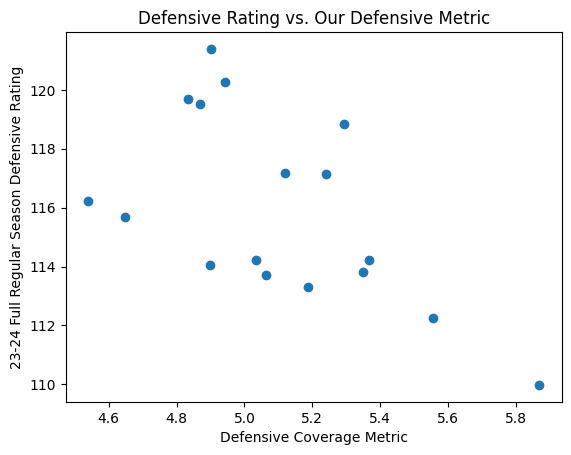

In [35]:
plt.scatter(merged_ratings['team_defense_coverage'], merged_ratings['DRtg'])
plt.title("Defensive Rating vs. Our Defensive Metric")
plt.xlabel("Defensive Coverage Metric")
plt.ylabel("23-24 Full Regular Season Defensive Rating")
plt.show()